In [1]:
import cv2
import tensorflow as tf
import pandas as pd
import math
import numpy as np
import os

from tqdm import tqdm

from random import shuffle
from matplotlib import pyplot as plt

from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import Sequence, to_categorical

from python_speech_features import mfcc, logfbank
from scipy.io import wavfile

In [2]:
AUDIOS_DIR = os.path.join("../datasets", "voxceleb1_wavfile")
num_classes = 300

def train_test_split():
    labels = sorted(os.listdir(AUDIOS_DIR))[:num_classes]
    train_files = []
    eval_files = []
    for label in labels:
        folder = os.path.join(AUDIOS_DIR, label)
        files = [os.path.join(folder, file) for file in os.listdir(folder) if file.endswith(".wav")]
        shuffle(files)
        split_idx = int(len(files) * 0.7)
        train_files.extend(files[:split_idx])
        eval_files.extend(files[split_idx:])
    return train_files, eval_files, labels

train_files, eval_files, labels = train_test_split()
print("Train files: {}".format(len(train_files)))
print("Eval files: {}".format(len(eval_files)))
print("Labels: {}".format(len(labels)))

Train files: 900
Eval files: 600
Labels: 300


In [3]:
def plot_signals(signals):
    nrows = len(signals)
    ncols = 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, sharey=True, figsize=(10, 20))
    fig.suptitle("Time Series", size=16)
    for x in range(nrows):
        axes[x].set_title(list(signals.keys())[x])
        axes[x].plot(list(signals.values())[x])
        axes[x].get_xaxis().set_visible(False)
        axes[x].get_yaxis().set_visible(True)
    fig.set_tight_layout(True)
    plt.show()

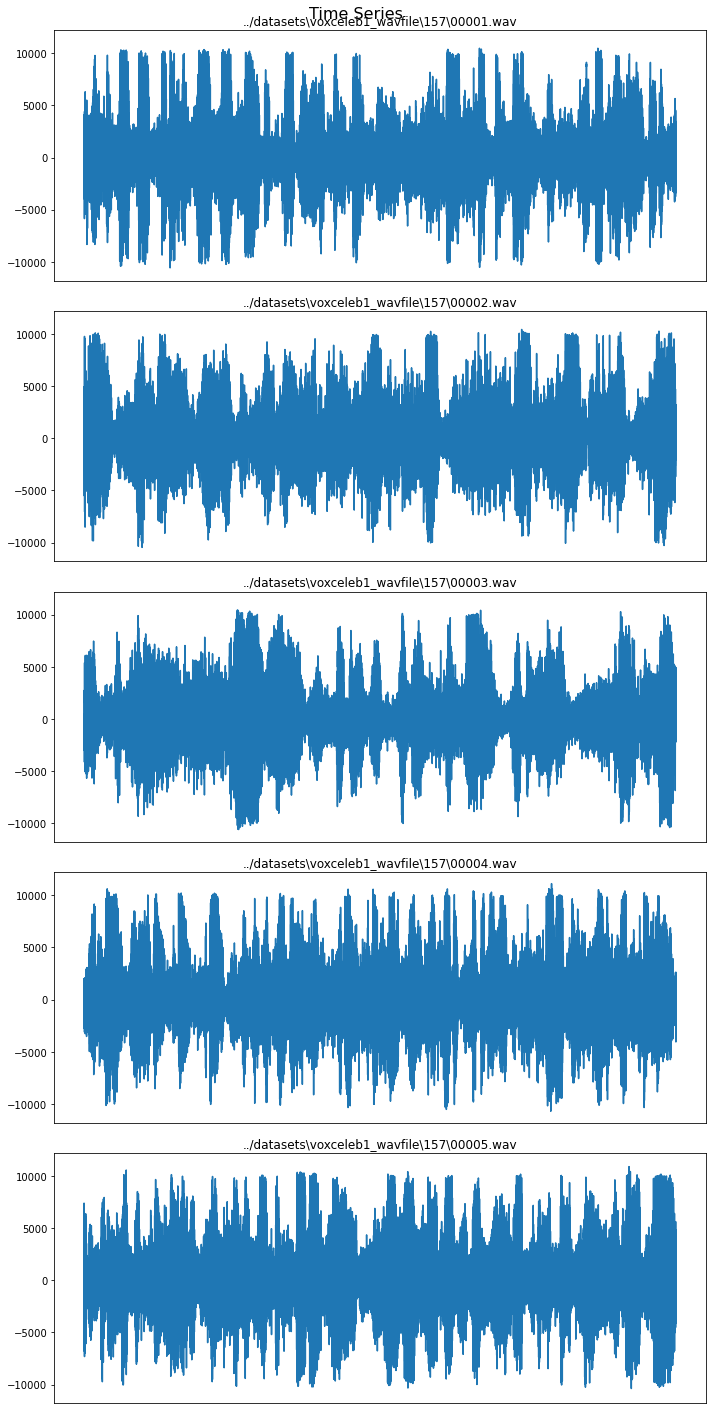

In [4]:
signals = {}
folder = os.listdir(AUDIOS_DIR)[156]
folder = os.path.join(AUDIOS_DIR, folder)
for file in os.listdir(folder):
    filepath = os.path.join(folder, file)
    if file.endswith(".wav"):
        signals[filepath] = wavfile.read(filepath)[1]
plot_signals(signals)

In [5]:
numcep = 13
nfilt = 26
nfft = 512
threshold = 200

def features_from_audio(audio_file, secs=0.1, n_samples=5):
    def envelop(signal, rate, threshold):
        mask = []
        y = pd.Series(signal).apply(np.abs)
        y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()
        for mean in y_mean:
            if mean > threshold:
                mask.append(True)
            else:
                mask.append(False)
        return mask
    rate, signal = wavfile.read(audio_file)
    mask = envelop(signal, rate, threshold)
    signal = signal[mask]
    step = int(rate*secs)
    samples = []
    for i in range(n_samples):
        rand_idx = np.random.randint(0, signal.shape[0]-step)
        sample = signal[rand_idx:rand_idx+step]
        sample = mfcc(sample, rate, numcep=numcep, nfilt=nfilt, nfft=nfft).astype(np.float32)
        sample = np.expand_dims(sample, axis=-1)
        samples.append(sample)
    return samples

In [6]:
train_audio_features = []
train_labels = []

eval_audio_features = []
eval_labels = []

n_samples_per_file = 5
# files = train_files + eval_files
# files = ['../datasets\\voxceleb1_wavfile\\157\\00004.wav']
failures = []
for file in tqdm(train_files):
    try:
        samples = features_from_audio(file, 0.1, n_samples_per_file)
    except Exception as e:
        failures.append(file)
        print(e)
    else:
        train_audio_features.extend(samples)
        train_labels.extend([os.path.basename(os.path.dirname(file)) for _ in range(n_samples_per_file)])
        
for file in tqdm(eval_files):
    try:
        samples = features_from_audio(file, 0.1, n_samples_per_file)
    except Exception as e:
        failures.append(file)
        print(e)
    else:
        eval_audio_features.extend(samples)
        eval_labels.extend([os.path.basename(os.path.dirname(file)) for _ in range(n_samples_per_file)])

print("Failures:", failures)
print(len(train_audio_features), len(train_labels))
print(len(eval_audio_features), len(eval_labels))

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:27<00:00, 21.82it/s]

Failures: []
4500 4500
3000 3000


In [7]:
len(eval_audio_features)

3000

In [8]:
class PersonIDSequence(Sequence):

    def __init__(self, features, labels, unique_labels, batch_size):
        self.features = features
        self.labels = labels
        self.unique_labels = unique_labels
#         shuffle(self.features)
        self.num_labels = len(self.unique_labels)
        self.batch_size = batch_size
        print(len(self.features), math.ceil(len(self.features) / self.batch_size))

    def __len__(self):
        return math.ceil(len(self.features) / self.batch_size)

    def __getitem__(self, idx):
        features = np.array(self.features[idx * self.batch_size:(idx + 1) * self.batch_size])
        y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        y_indices = [to_categorical(self.unique_labels.index(i), num_classes=self.num_labels)
                     for i in y]
        return features, np.array(y_indices)

    def on_epoch_end(self):
#         shuffle(self.files)
        shuffler = np.random.permutation(len(self.features))
        self.features = self.features[shuffler]
        self.labels = self.labels[shuffler]
        pass


In [9]:
def audio_model():
    input_ = layers.Input(shape=(9, 13, 1))
    x = layers.Conv2D(256, 3, strides=(1, 1), padding='same')(input_)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(256, 3, strides=(1, 1), padding='same')(input_)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(256, 3, strides=(1, 1), padding='same')(input_)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    
#     x = layers.Dropout(0.5)(x)
#     x = layers.Dense(1024, activation='relu')(x)
    
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(300, name='last_dense')(x)
    x = layers.Softmax()(x)

    model = Model(inputs=input_, outputs=x, name='audio_model_cnn')
    return model

model = audio_model()
# model.summary()

In [10]:
unique_labels = sorted(np.unique(train_labels))
train_ds = PersonIDSequence(train_audio_features, train_labels, unique_labels, batch_size=64)
eval_ds = PersonIDSequence(eval_audio_features, eval_labels, unique_labels, batch_size=64)

4500 71
3000 47


In [11]:
epochs = 80
lr = 0.001

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(lr))
history = model.fit(train_ds, epochs=epochs, validation_data=eval_ds)

Train for 71 steps, validate for 47 steps
Epoch 1/80
71/71 [==============================] - 3s 40ms/step - loss: 18.1042 - accuracy: 0.0000e+00 - val_loss: 14.5429 - val_accuracy: 0.0050
Epoch 2/80
71/71 [==============================] - 1s 8ms/step - loss: 12.3009 - accuracy: 6.6667e-04 - val_loss: 12.7824 - val_accuracy: 0.0147
Epoch 3/80
71/71 [==============================] - 1s 8ms/step - loss: 11.0808 - accuracy: 0.0080 - val_loss: 9.7357 - val_accuracy: 0.0257
Epoch 4/80
71/71 [==============================] - 1s 8ms/step - loss: 8.8829 - accuracy: 0.0173 - val_loss: 8.7470 - val_accuracy: 0.0310
Epoch 5/80
71/71 [==============================] - 1s 9ms/step - loss: 7.8049 - accuracy: 0.0211 - val_loss: 7.8605 - val_accuracy: 0.0350
Epoch 6/80
71/71 [==============================] - 1s 8ms/step - loss: 6.5946 - accuracy: 0.0353 - val_loss: 6.9933 - val_accuracy: 0.0433
Epoch 7/80
71/71 [==============================] - 1s 8ms/step - loss: 5.7251 - accuracy: 0.0498 - val_

Epoch 59/80
71/71 [==============================] - 1s 8ms/step - loss: 0.2814 - accuracy: 0.9227 - val_loss: 9.5219 - val_accuracy: 0.0770
Epoch 60/80
71/71 [==============================] - 1s 8ms/step - loss: 0.5208 - accuracy: 0.8736 - val_loss: 9.8824 - val_accuracy: 0.0637
Epoch 61/80
71/71 [==============================] - 1s 8ms/step - loss: 0.4753 - accuracy: 0.8729 - val_loss: 8.9281 - val_accuracy: 0.0717
Epoch 62/80
71/71 [==============================] - 1s 8ms/step - loss: 0.2544 - accuracy: 0.9391 - val_loss: 8.6466 - val_accuracy: 0.0760
Epoch 63/80
71/71 [==============================] - 1s 8ms/step - loss: 0.1397 - accuracy: 0.9816 - val_loss: 8.3029 - val_accuracy: 0.0857
Epoch 64/80
71/71 [==============================] - 1s 8ms/step - loss: 0.1072 - accuracy: 0.9884 - val_loss: 8.1905 - val_accuracy: 0.0917
Epoch 65/80
71/71 [==============================] - 1s 8ms/step - loss: 0.0546 - accuracy: 0.9960 - val_loss: 8.2238 - val_accuracy: 0.0913
Epoch 66/80
7

In [12]:
model.evaluate(eval_ds)

47/47 [==============================] - 0s 4ms/step - loss: 9.5335 - accuracy: 0.0893


[9.533499859749003, 0.08933333]

In [13]:
model.save("audio_model_e{}_lr{}.h5".format(epochs, lr))

In [14]:
model.summary()

Model: "audio_model_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9, 13, 1)]        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 13, 256)        2560      
_________________________________________________________________
batch_normalization_2 (Batch (None, 9, 13, 256)        1024      
_________________________________________________________________
re_lu_2 (ReLU)               (None, 9, 13, 256)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 6, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6144)              0         
_________________________________________________________________
dropout (Dropout)            (None, 6144)          